In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from collections import defaultdict

from sklearn import model_selection, naive_bayes, svm, datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from yellowbrick.classifier import ClassPredictionError

import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# read in & format data
data = 'hatespeech_dataset.csv'

df = pd.read_csv(data)
df=df[['class', 'tweet']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [ ]:
# text preprocessing
# 1. Removing Blank Spaces
df['tweet'].dropna(inplace=True)
# 2. Changing all text to lowercase
df['tweet_og'] = df['tweet']
df['tweet'] = [entry.lower() for entry in df['tweet']]
# 3. Tokenization-In this each entry in the corpus will be broken into set of words
df['tweet']= [word_tokenize(entry) for entry in df['tweet']]
# 4. Remove Stop words, Non-Numeric and perfoming Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(df['tweet']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word not in ['!', '@', 'rt'] and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'tweet_processed'] = str(Final_words)

df.drop(['tweet'], axis=1)
output_path = 'preprocessed_data.csv'
df.to_csv(output_path, index=False)

In [51]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df['tweet_processed'],df['class'], train_size=0.80, test_size=0.20, random_state=101)

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [52]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['tweet_processed'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

# print(Tfidf_vect.vocabulary_)

In [53]:
rbf = svm.SVC(kernel='rbf', gamma='auto', C=0.1)
rbf.fit(Train_X_Tfidf,y_train)
rbf_pred = rbf.predict(Test_X_Tfidf)
print("RBF kernel SVM Accuracy Score -> ",accuracy_score(rbf_pred, y_test)*100)
print(classification_report(y_test,rbf_pred))

RBF kernel SVM Accuracy Score ->  77.56707686100464
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.78      1.00      0.87      3845
           2       0.00      0.00      0.00       820

    accuracy                           0.78      4957
   macro avg       0.26      0.33      0.29      4957
weighted avg       0.60      0.78      0.68      4957



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
poly = svm.SVC(kernel='poly', degree=3, C=1)
poly.fit(Train_X_Tfidf,y_train)
poly_pred = poly.predict(Test_X_Tfidf)
print(" Polynomial kernel SVM Accuracy Score -> ",accuracy_score(poly_pred, y_test)*100)
print(classification_report(y_test,poly_pred))

 Polynomial kernel SVM Accuracy Score ->  78.99939479523906
              precision    recall  f1-score   support

           0       0.67      0.03      0.07       292
           1       0.79      1.00      0.88      3845
           2       0.90      0.09      0.16       820

    accuracy                           0.79      4957
   macro avg       0.79      0.37      0.37      4957
weighted avg       0.80      0.79      0.71      4957



In [55]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
lin = svm.SVC(C=1.0, kernel='linear')
lin.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
lin_pred = lin.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("linear kernel SVM Accuracy Score -> ",accuracy_score(lin_pred, y_test)*100)
print(classification_report(y_test,lin_pred))

linear kernel SVM Accuracy Score ->  91.0026225539641
              precision    recall  f1-score   support

           0       0.65      0.18      0.28       292
           1       0.93      0.96      0.95      3845
           2       0.84      0.92      0.88       820

    accuracy                           0.91      4957
   macro avg       0.81      0.69      0.70      4957
weighted avg       0.90      0.91      0.90      4957



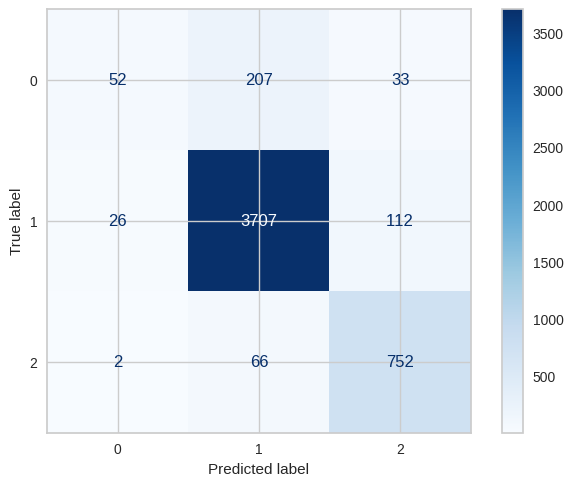

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, lin_pred, cmap='Blues')

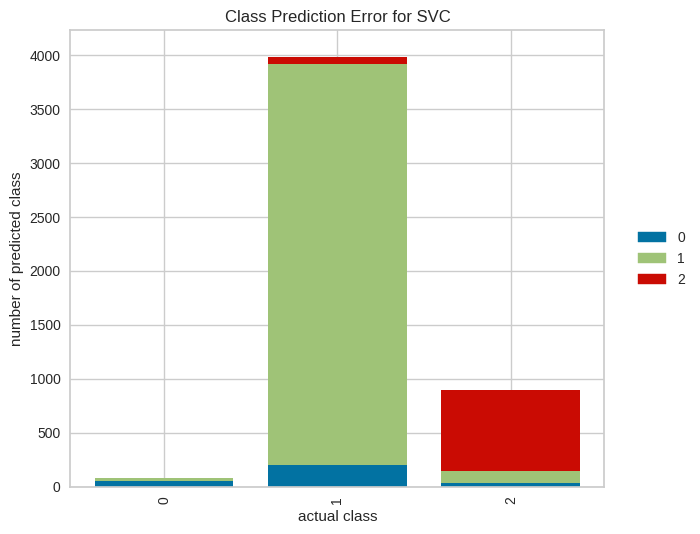

In [58]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    lin, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(Train_X_Tfidf,y_train)

# Evaluate the model on the test data
visualizer.score(Test_X_Tfidf, y_test)

# Draw visualization
g = visualizer.poof()